In [1]:
import pandas as pd
from unicodedata import numeric

"""
lib installation instructions:

conda create -n faiss_env python=3.9
conda activate faiss_env
conda install -c conda-forge faiss
pip install pandas==1.2.5
pip install numpy==1.25.1
pip install transformers
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
pip install pycap==1.1.2
pip install scipy==1.13.1
pip install scikit-learn==1.5.2
pip install accelerate>=0.26.0
"""

'\nlib installation instructions:\n\nconda create -n faiss_env python=3.9\nconda activate faiss_env\nconda install -c conda-forge faiss\npip install pandas==1.2.5\npip install numpy==1.25.1\npip install transformers\npip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\npip install pycap==1.1.2\npip install scipy==1.13.1\npip install scikit-learn==1.5.2\npip install accelerate>=0.26.0\n'

In [14]:
import pickle
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from data_gen import *

In [3]:
"""Getting all CMR data from REDCap"""
rc_label = False
meta_data, demo, pt_hx, cath, cmr, echo, ex_str_tst, pt_stat_upd, cl_pt_level, cl_cmr_level = fetch_data(rc_label)

C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\redcap\project.py:472: DtypeWarning: Columns (5,11,12,14,15,16,17,37,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,122,123,124,125,126,127,128,129,130,131,145,146,149,152,155,158,161,164,167,170,173,176,179,180,181,184,187,191,194,197,200,203,204,205,206,207,210,213,218,221,224,241,242,243,246,249,252,255,258,261,264,267,270,273,276,279,282,285,288,291,292,293,296,299,302,305,306,307,317,318,319,320,321,322,323,324,325,326,327,330,333,336,339,342,345,348,351,354,369,370,371,372,374,375,376,377,380,383,384,385,388,391,392,395,396,399,400,401,402,403,404,405,406,407,408,409,410,411,414,417,418,421,424,427,430,433,436,439,442,445,448,451,454,457,460,462,463,465,468,469,470,471,472,473,474,475,476,477,478,479,480,481,

In [53]:
"""
Data cleaning
"""
# adding 0 for repeat instance for demo, pt_hx and pt_status_upd
demo['redcap_repeat_instance'] = 0
pt_hx['redcap_repeat_instance'] = 0
pt_stat_upd['redcap_repeat_instance'] = 0

# removing text data in numeric columns
pt_hx['surg_cardiac_total'] = pt_hx['surg_cardiac_total'].apply(lambda x: np.nan if isinstance(x, str) else x)
pt_stat_upd['hx_ecmo_cannulations'] = pt_stat_upd['hx_ecmo_cannulations'].apply(lambda x: np.nan if isinstance(x, str) else x)

# only retaining earliest/latest CMRs
earliest_latest_indicator = 'first' # 'first', 'last'
cmr['cmr_date'] = pd.to_datetime(cmr['cmr_date'])
cmr = cmr.sort_values(by=['force_id', 'cmr_date']).drop_duplicates(subset='force_id', keep=earliest_latest_indicator).reset_index(drop=True)
cmr['redcap_repeat_instance'] = 1

# only retaining latest Status update forms
earliest_latest_indicator = 'last' # 'first', 'last'
pt_stat_upd['status_date_alive'] = pd.to_datetime(pt_stat_upd['status_date_alive'])
pt_stat_upd = pt_stat_upd.sort_values(by=['force_id', 'status_date_alive']).drop_duplicates(subset='force_id', keep=earliest_latest_indicator).reset_index(drop=True)

In [54]:
"""only using pts passed QA"""
not_passed_qa = [fid for fid, ready_pmt_date in zip(cl_cmr_level.force_id, cl_cmr_level.cl_payment_ready_date) if ready_pmt_date is np.nan]
passed_qa = [fid for fid in cl_cmr_level.force_id if fid not in not_passed_qa]

dfs = [demo, cmr, cath, pt_stat_upd, pt_hx, echo, ex_str_tst]
new_dfs = []
for df in dfs:
    # getting rid of mean/stdev cols
    std_cols = [col for col in df.columns if 'stdev' in col]
    mean_cols = [col.replace('_stdev', '_mean') for col in std_cols]
    df = df[[col for col in df.columns if col not in std_cols and col not in mean_cols]]
    new_dfs.append(df[df['force_id'].isin(passed_qa)])
    
demo = new_dfs[0]
cmr = new_dfs[1]
cath = new_dfs[2]
pt_stat_upd = new_dfs[3]
pt_hx = new_dfs[4]
echo = new_dfs[5]
ex_str_tst = new_dfs[6]


In [56]:
"""
looking for text vs numeric fields
"""
calc_map = {'cmr_sv_ef': "Single ventricle ejection fraction",
            "cmr_sv_sv": "Single ventricle systolic volume",
            "cmr_bmi": "Body mass index",
            "cmr_mass_height27": "Mass to height volume indexed on BSA (exp = 2.7)",
            'cmr_sv_esv': 'Single ventricle end systolic volume',
            'cmr_sv_esv_bsa1':'Single ventricle end systolic volume indexed on BSA (exp = 1)',
            'cmr_sv_esv_bsa13':'Single ventricle end systolic volume indexed on BSA (exp = 1.3)' ,
            'cmr_sv_edv': 'Single ventricle end diastolic volume',
            'cmr_sv_edv_bsa1':'Single ventricle end diastolic volume indexed on BSA (exp = 1)',
            'cmr_sv_edv_bsa13':'Single ventricle end diastolic volume indexed on BSA (exp = 1.3)' ,
            'cmr_sv_mass': 'Single ventricle mass',
            'cmr_sv_mass_bsa1':'Single ventricle mass indexed on BSA (exp = 1)',
            'cmr_sv_mass_bsa13': 'Single ventricle mass indexed on BSA (exp = 1.3)',
            'cmr_sv_mvr': 'Single ventricle mass to volume ratio',
            'cmr_sv_mvr_bsa1':'Single ventricle mass to volume ratio indexed on BSA (exp = 1)',
            'cmr_sv_mvr_bsa13':'Single ventricle mass to volume ratio indexed on BSA (exp = 1.3)'
           }


text_fields = meta_data[meta_data['field_type'] == 'text']
# df_dict_map = {'demographic_data': demo, 'pt_clinical_surgical_history': pt_hx, 'catheterization': cath, 'cmr': cmr, 'echocardiogram': echo, 'exercise_stress_test': ex_str_tst, 'pt_status_event_update': pt_stat_upd}

df_dict_map = {'demographic_data': demo, 'pt_clinical_surgical_history': pt_hx, 'cmr': cmr, 'pt_status_event_update': pt_stat_upd}

text_cols = []
numeric_cols = []

field_names = meta_data.field_name.values
form_names = meta_data.form_name.values
field_types = meta_data.field_type.values
for field_name, form_name, field_type in zip(field_names, form_names, field_types):
    if field_type == 'text' and form_name in df_dict_map.keys():
        df_curr = df_dict_map[form_name]
        if field_name in df_curr.columns and df_curr.dropna(subset=[field_name]).shape[0] > 0:            
            series_curr = df_curr[field_name]
            try:
                series_curr.astype(float)
                numeric_cols.append(field_name)
            except:
                text_cols.append(field_name)

numeric_cols = numeric_cols + list(calc_map.keys())
year_cols = [col for col in numeric_cols if 'year' in col.lower()]
numeric_cols = [col for col in numeric_cols if col not in year_cols]

In [57]:
"""logic for coercing check box variables"""
chk_box_df = meta_data[meta_data['field_type'].isin(['checkbox'])]

chk_box_df_names = chk_box_df['form_name'].values
chk_box_cols = chk_box_df['field_name'].values

chk_cols = []
fail_cases = []
for col, dfn in zip(chk_box_cols, chk_box_df_names):
    if dfn in df_dict_map.keys():
        df_curr = df_dict_map[dfn]
        val_list=str(meta_data[meta_data['field_name']==col]['select_choices_or_calculations'].values)[2:].split('|')
        val_dic={",".join((v.split(',')[1:]))[1:-1].replace("'", ""): int(v.split(',')[0].replace(" ", "")) for v in val_list}
        for idx in val_dic.values():
            chk_col = col + '___' + str(idx)
            try:
                df_curr[chk_col]
                chk_cols.append(chk_col)
            except:
                fail_cases.append(chk_col)    

In [89]:
"""Getting rest of text/numeric fields"""
categorical_fields = meta_data[meta_data['field_type'].isin(['dropdown', 'radio', 'yesno'])]
categorical_fields = categorical_fields[categorical_fields['form_name'].isin(df_dict_map.keys())][
    'field_name'].values
categorical_fields = list(categorical_fields)
categorical_fields = categorical_fields + chk_cols
categorical_fields = [col for col in categorical_fields if col != 'site_name']
categorical_fields = [col for col in categorical_fields if 'month' not in col and 'mnth' not in col]

text_add_fields = meta_data[meta_data['field_type'].isin(['notes'])]
text_add_fields = text_add_fields[text_add_fields['form_name'].isin(df_dict_map.keys())]['field_name'].values
text_cols = text_cols + list(text_add_fields) + year_cols
text_cols = [col for col in text_cols if 'recorded' not in col]

In [90]:
"""
Pre-processing for data based on data type (numeric: standardize, text: create embeddings)
key references: 
df_dict_map: reference df based on form_name in metadata dictionary
text_cols: text based columns (reference col in metadata dictionary using field_name)
numeric_cols: numeric based freetext columns (reference col in metadata dictionary using field_name)
numeric_add_fields: categorical data (checkbox, yesno, dropdown, radio)` 
"""

'\nPre-processing for data based on data type (numeric: standardize, text: create embeddings)\nkey references: \ndf_dict_map: reference df based on form_name in metadata dictionary\ntext_cols: text based columns (reference col in metadata dictionary using field_name)\nnumeric_cols: numeric based freetext columns (reference col in metadata dictionary using field_name)\nnumeric_add_fields: categorical data (checkbox, yesno, dropdown, radio)` \n'

In [272]:
"""1. Normalizing numeric_cols"""
def normalize_numeric_data(df_dict_map, numeric_cols, meta_data, calc_map):
    # Initialize scalers
    standard_scaler = StandardScaler()
    min_max_scaler = MinMaxScaler()

    # Dictionary to hold normalized data
    normalized_numeric_data_dict = {'force_id': []}

    # Normalizing numeric columns
    fid_indic = 0
    for col in numeric_cols:
        if col in calc_map.keys():
            form_nm_curr = 'cmr'
            df_curr = df_dict_map[form_nm_curr]
        else:
            form_nm_curr = meta_data[meta_data['field_name'] == col]['form_name'].values[0]
            df_curr = df_dict_map[form_nm_curr]

        # Fit-transform or transform based on the scaler of choice
        # Here, we'll use z-score normalization as an example
        df_curr[col + "_norm"] = standard_scaler.fit_transform(df_curr[[col]])
        # Process each row in df_curr to store in the dictionary
        for _, row in df_curr.iterrows():
            if fid_indic == 0:
                normalized_numeric_data_dict['force_id'].append(row['force_id'])

            if col not in normalized_numeric_data_dict.keys():
                normalized_numeric_data_dict[col] = [row[col + '_norm']]
            else:
                normalized_numeric_data_dict[col].append(row[col + "_norm"])
        
        fid_indic += 1

    return normalized_numeric_data_dict

In [273]:
"""1. Normalizing numeric_cols"""
def noncategory_data_agg(ori_data_dict, df_dict_map, add_fields, meta_data):
    for col in add_fields:
        if '___' in col:
            form_nm_curr = meta_data[meta_data['field_name'] == col.split('___')[0]]['form_name'].values[0]
        else:
            form_nm_curr = meta_data[meta_data['field_name'] == col]['form_name'].values[0]
        df_curr = df_dict_map[form_nm_curr]
        # Process each row in df_curr to store in the dictionary
        for _, row in df_curr.iterrows():

            if col not in ori_data_dict.keys():
                ori_data_dict[col] = [row[col]]
            else:
                ori_data_dict[col].append(row[col])

    return ori_data_dict


In [276]:
normalized_numeric_data_dict = normalize_numeric_data(df_dict_map, numeric_cols, meta_data, calc_map)
xgboost_data_dict = noncategory_data_agg(normalized_numeric_data_dict, df_dict_map, categorical_fields, meta_data)

In [294]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

xgboost_data_df = pd.DataFrame(xgboost_data_dict)
xgboost_data_df = xgboost_data_df.drop('force_id', axis=1)
psu_grps = pd.read_csv('Pt Status Update Table Associated Variables.csv')
psu_grps = [[val for val in vals if str(val) != 'nan'] for vals in psu_grps.values]

grp_leads_to_keep_unlab = ['hx_seizures',
                           'hx_ep_pacemaker',
                           'hx_ascites',
                           'status_death',
                           'hx_tx_received'
                           ]

grp_leads_to_keep = ['Does the patient have a diagnosis of seizures requiring antiepileptic medications?',
                     'Does the patient have a history of pacemaker placement?',
                     'Does the patient have a history of ascites (> trace)?',
                     'Has the patient died?',
                     'Did the patient receive a heart transplant?'
                     ]

acc_dict = {'outcome': [], 'acc': []}
for glkeep_lab, glkeep in zip(grp_leads_to_keep, grp_leads_to_keep_unlab):
    drop_cols = [grp for grp in psu_grps if glkeep in grp][0]
    drop_cols = [col for col in drop_cols if col in xgboost_data_df.columns]
    # 1. Prepare the data
    # Assuming `train_xgboost_df` has features and a target column named 'outcome'
    xgb_df_curr = xgboost_data_df[~xgboost_data_df[glkeep].isna()]
    X = xgb_df_curr.drop(columns=drop_cols)
    y = xgb_df_curr[glkeep]
    y = y.replace({99: 0})

    # 2. Train-Test Split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 3. Initialize and Train the XGBoost Model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,  # Number of trees
        learning_rate=0.1,  # Step size shrinkage
        max_depth=3,  # Maximum depth of a tree
        random_state=42,
        use_label_encoder=False,  # Disable label encoding (deprecated in XGBoost)
        eval_metric="logloss"  # Evaluation metric
    )

    xgb_model.fit(X_train, y_train)

    # 4. Make Predictions
    y_pred = xgb_model.predict(X_val)
    y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]  # Probability of the positive class

    # 5. Evaluate the Model
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)
    
    acc_dict['outcome'].append(glkeep_lab)
    acc_dict['acc'].append(accuracy)
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # # Optional: Feature Importance Plot
    # xgb.plot_importance(xgb_model, importance_type="weight")

    # # Optional: Feature Importance Plot
    # xgb.plot_importance(xgb_model, importance_type="weight")
    

C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.93
AUC: 0.74

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.96       700
         1.0       0.25      0.02      0.04        49

    accuracy                           0.93       749
   macro avg       0.59      0.51      0.50       749
weighted avg       0.89      0.93      0.90       749



C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
AUC: 1.00

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       699
         1.0       1.00      1.00      1.00        49

    accuracy                           1.00       748
   macro avg       1.00      1.00      1.00       748
weighted avg       1.00      1.00      1.00       748



C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.93
AUC: 0.89

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       688
         1.0       0.61      0.33      0.43        60

    accuracy                           0.93       748
   macro avg       0.78      0.66      0.70       748
weighted avg       0.92      0.93      0.92       748



C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.96
AUC: 0.86

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       715
         1.0       0.50      0.13      0.21        31

    accuracy                           0.96       746
   macro avg       0.73      0.56      0.59       746
weighted avg       0.94      0.96      0.95       746

Accuracy: 0.98
AUC: 0.90

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       732
         1.0       0.67      0.12      0.20        17

    accuracy                           0.98       749
   macro avg       0.82      0.56      0.59       749
weighted avg       0.97      0.98      0.97       749



C:\Users\gjm31\anaconda3\envs\rag_env\lib\site-packages\xgboost\core.py:158: UserWarning: [10:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [283]:
class_report = classification_report(y_val, y_pred)
class_report.items()

AttributeError: 'str' object has no attribute 'items'

In [279]:
# Path to save the normalized numeric data dictionary
if not os.path.exists('./results'):
    os.mkdir('./results')

save_path = "xgboost_data.pkl"

# Save the dictionary
with open('./results/' + save_path, "wb") as f:
    pickle.dump(xgboost_data_dict, f)

In [280]:
xgboost_data_dict.keys()

dict_keys(['force_id', 'surg_cardiac_total', 'cmr_contrast_dose', 'cmr_contrast_agent_dose_gadobutrol', 'cmr_contrast_agent_dose_gadoteric', 'cmr_contrast_agent_dose_gadoteridol', 'cmr_contrast_agent_dose_gadobenate', 'cmr_contrast_agent_dose_gadopentetate', 'cmr_contrast_agent_dose_gadodiamide', 'cmr_contrast_agent_dose_gadoversetamide', 'cmr_contrast_agent_dose_gadofosveset', 'cmr_contrast_agent_dose_gadoxetic', 'cmr_contrast_agent_dose_unknown', 'cmr_contrast_agent_dose_ferumoxytol', 'cmr_contrast_agent_dose_other', 'cmr_pt_hct', 'cmr_pt_height', 'cmr_pt_weight', 'cmr_pt_bsa', 'cmr_pt_hr', 'cmr_pt_bp_sys', 'cmr_pt_bp_dias', 'cmr_pt_bp_mean', 'cmr_o2_sat', 'cmr_lv_edv', 'cmr_lv_esv', 'cmr_lv_mass', 'cmr_rv_edv', 'cmr_rv_esv', 'cmr_rv_mass', 'cmr_flow_native_ao', 'cmr_flow_neo_ao', 'cmr_flow_asc_ao', 'cmr_flow_desc_ao', 'cmr_flow_rsvc', 'cmr_flow_lsvc', 'cmr_flow_fontan', 'cmr_flow_ivc', 'cmr_flow_rpa', 'cmr_flow_lpa', 'cmr_flow_rpv', 'cmr_flow_lpv', 'cmr_flow_avv', 'cmr_flow_avv_tri'

In [286]:
# acc_dict['outcome'].append('total')
# acc_dict['acc'].append(np.mean(acc_dict['acc']))

In [289]:
acc_df = pd.DataFrame.from_dict(acc_dict)
acc_df

,outcome,acc
0,hx_seizures,0.931909
1,hx_ep_pacemaker,1.000000
2,hx_ascites,0.929144
3,status_death,0.958445
4,hx_tx_received,0.978638
5,total,0.959627


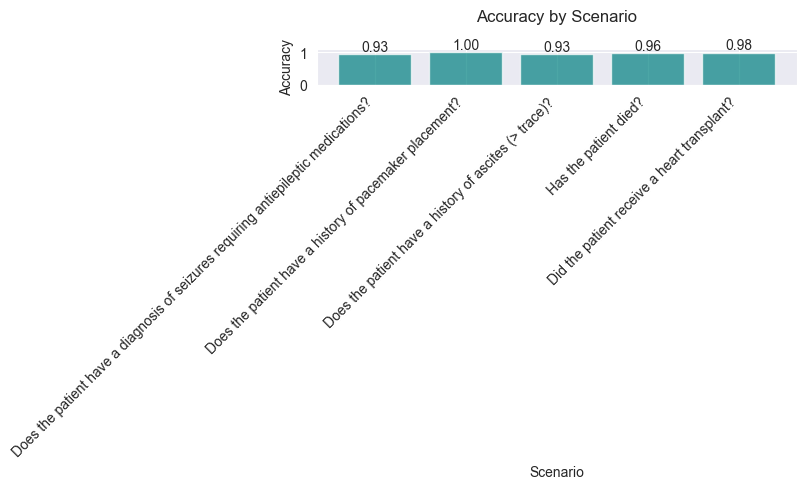

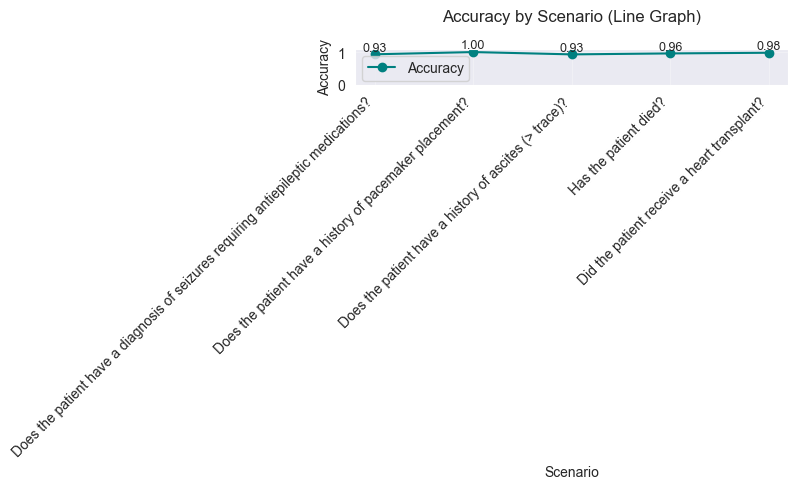

In [295]:
import matplotlib.pyplot as plt

# Convert to lists for plotting
scenarios = acc_dict['outcome']
accuracies = acc_dict['acc']

# Bar Graph
plt.figure(figsize=(8, 5))
bars = plt.bar(scenarios, accuracies, color='teal', alpha=0.7)
plt.title('Accuracy by Scenario', pad=20)
plt.ylabel('Accuracy')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')

# Add labels above bars
for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f'{acc:.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.ylim(0, 1.1)  # Ensure sufficient space above bars
plt.tight_layout()
plt.show()

# Line Graph
plt.figure(figsize=(8, 5))
plt.plot(scenarios, accuracies, marker='o', color='teal', label='Accuracy')
plt.title('Accuracy by Scenario (Line Graph)', pad=20)
plt.ylabel('Accuracy')
plt.xlabel('Scenario')
plt.xticks(rotation=45, ha='right')

# Add labels at each point
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=9)

plt.ylim(0, 1.1)  # Ensure sufficient space above points
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()